# Moving Average

## Introduction

- In this section, we will build upon that knowledge and explore another important concept called **smoothing**.
- In particular, we will cover:
    1. An introduction to smoothing and why it is necessary.
    2. Common smoothing techniques.
    3. How to smooth time series data with Python and generate forecasts.

In [106]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import yfinance as yf
np.random.seed(42) # reproducibility

def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

---

## Smoothing

- A data collection process is often affected by noise. 
- If too strong, the noise can conceal useful patterns in the data. 
- Smoothing is a well-known and often-used technique to recover those patterns by *filtering out noise*.
- It can also be used to *make forecasts* by projecting the recovered patterns into the future.

- We start by generating some stationary data.
- We discussed the importance of visually inspecting the time series with a run-sequence plot. 
- So, we will also define the `run_sequence_plot` function to visualize our data.

In [107]:
# Generate stationary data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

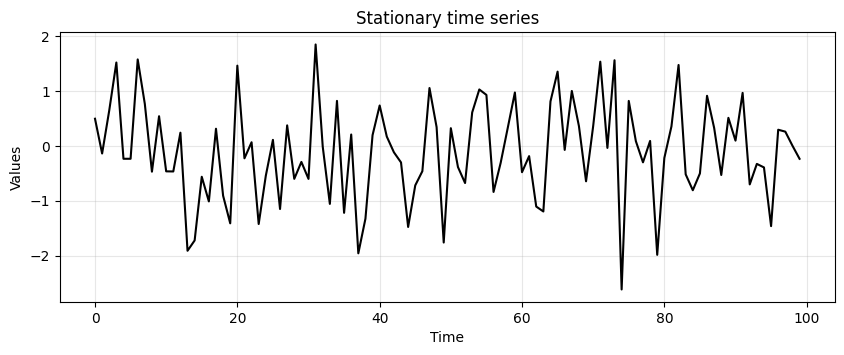

In [108]:
run_sequence_plot(time, stationary, title="Stationary time series");

---

## Simple smoothing techniques

- There are many techniques for smoothing data. 
- The most simple ones are:
    1. Simple average
    2. Moving average
    3. Weighted moving average

### Simple average

- Simple average is the most basic technique. 
- Consider the stationary data above.
- The most conservative way to represent it is through its **mean**.
- The mean can be used to predict the future values of the time series.
- This type of representation is called *simple average*.

In [109]:
# find mean of series
stationary_time_series_avg = np.mean(stationary)

# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_avg, dtype='float')

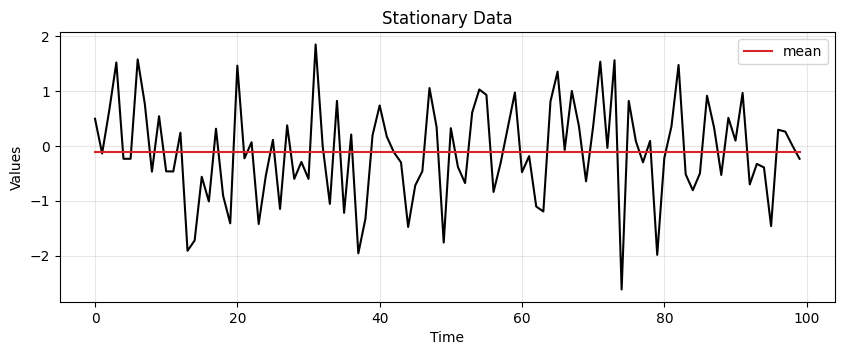

In [110]:
ax = run_sequence_plot(time, stationary, title="Stationary Data")
ax.plot(time, sts_avg, 'tab:red', label="mean")
plt.legend();

Exceptional! But we can do better...

### Mean squared error (MSE)

- The approximation with the mean seems reasonable in this case.
- In general we want to measure how far off our estimate is from reality. 
- A common way of doing it is by calculating the *Mean Squared Error* (MSE) 

$$MSE = \frac{1}{T}\sum_{t=1}^{T} (X(t) - \hat{X}(t))^2$$

- where $X(t)$ and $\hat{X}(t)$ are the true and estimated values at time $t$, respectively. 

![MSE Visualization](media/MSEVisualization.gif)

In [111]:
def mse(observations, estimates):

    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = np.mean(sq_diff)
    
    return mse

In [112]:
y_true = np.array([2, 3, 1, 4, 3, 5, 4, 6, 5, 7])
y_pred = np.array([2.5, 1.0, 3.5, 3.8, 6.0, 4.5, 5.5, 4.0, 6.5, 7.5])

zeros = mse(y_true, y_pred)
print(zeros)

2.854


- Next, we add a *trend* to our stationary time series.

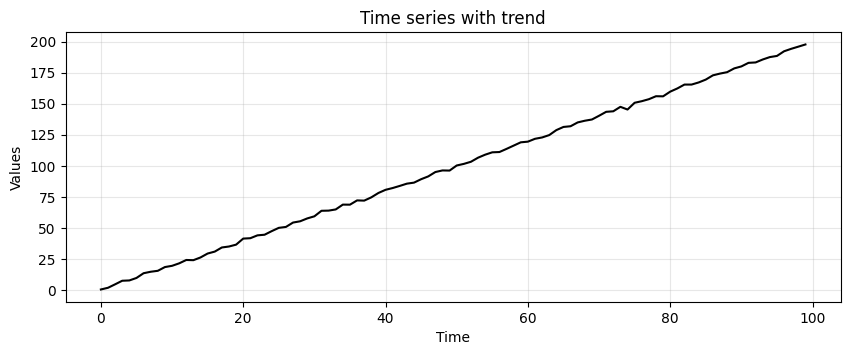

In [113]:
trend = (time * 2.0) + stationary
run_sequence_plot(time, trend, title="Time series with trend");

- Let's try our simple average again!

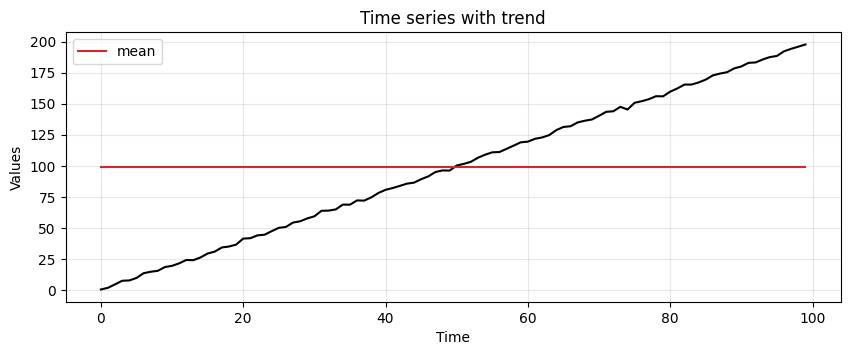

In [114]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
avg_trend = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time, avg_trend, 'tab:red', label="mean")
plt.legend();

- We must find other ways to capture the underlying pattern in the data. 
- We start with something called a *moving average*.

### Moving Average (MA)

- Moving average has a greater sensitivity than the simple average to local changes in the data.
- The easiest way to understand moving average is by example. 

- The first step is to select a window size. 
- We'll arbitrarily choose a size of 3. 
- Then, we start computing the average for the first three values and store the result. 
- We then slide the window by one and calculate the average of the next three values. 
- We repeat this process until we reach the final observed value. 

![MA](media/MA3.gif)

- Now, let's define a function to perform smoothing with the MA.
- Then, we compare the MSE obtained from applying simple and moving average on the data with trend. 

In [115]:
def moving_average(observations, window=3, forecast=False):
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    ma = cumulative_sum[window - 1:] / window
    if forecast:
        observations = np.append(observations, np.nan)
        ma_forecast = np.insert(ma, 0, np.nan*np.ones(window))
        return observations, ma_forecast
    else:
        return ma

In [116]:
MA_trend = moving_average(trend, window=3)

print(f"MSE:\n--------\nsimple average: {mse(trend, avg_trend):.2f}\nmoving_average: {mse(trend[2:], MA_trend):.2f}")

MSE:
--------
simple average: 3338.46
moving_average: 4.56


- We can tell that the MA manages to pick up the trend much better
- Let's plot the moving average to see what it is doing

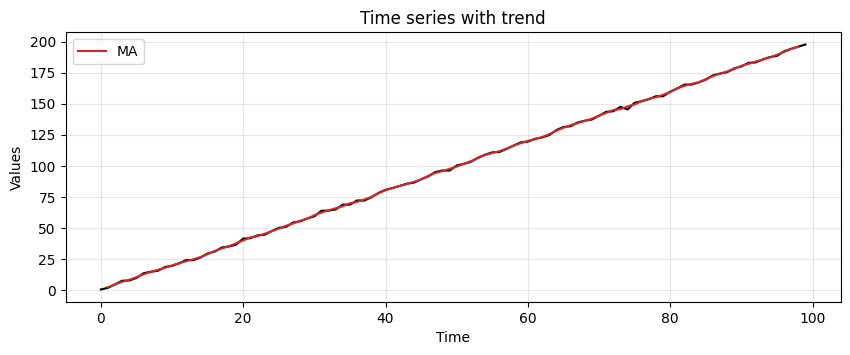

In [117]:
run_sequence_plot(time, trend, title="Time series with trend")
plt.plot(time[1:-1], MA_trend, 'tab:red', label="MA")
plt.legend();

- Let's up the ante, we'll introduce some seasonality

In [118]:
seasonality = 10 + np.sin(time) * 10 + stationary
MA_seasonality = moving_average(seasonality, window=3)

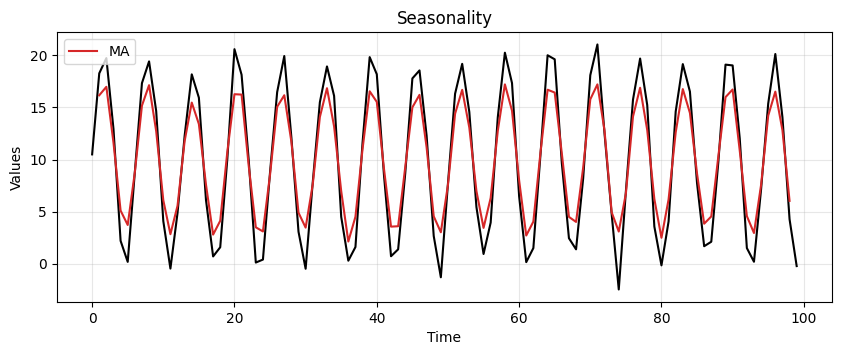

In [119]:
run_sequence_plot(time, seasonality, title="Seasonality")
plt.plot(time[1:-1], MA_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- It's not perfect but clearly picks up the periodic pattern.
- Lastly, let's see how MA handles trend, seasonality, and a bit of noise.

In [120]:
trend_seasonality = trend + seasonality + stationary
MA_trend_seasonality = moving_average(trend_seasonality, window=3)

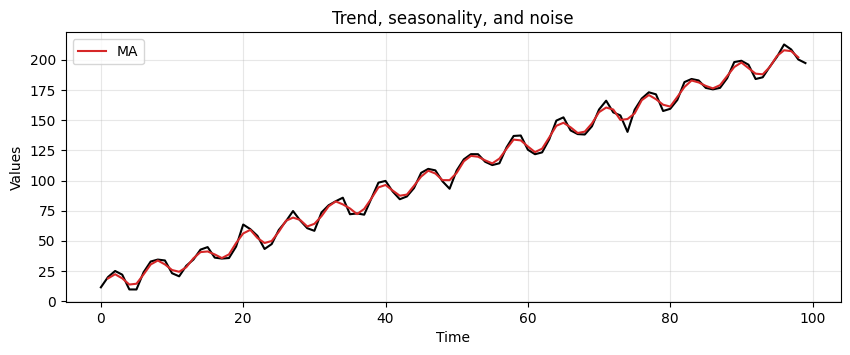

In [121]:
run_sequence_plot(time, trend_seasonality, title="Trend, seasonality, and noise")
plt.plot(time[1:-1], MA_trend_seasonality, 'tab:red', label="MA")
plt.legend(loc='upper left');

- This method is picking up key patterns in these toy datasets. 
- However, it has several limitations.

1. MA assigns equal importance to all values in the window, regardless of their chronological order. 
    - For this reason it fails in capturing the often more relevant recent trends.

2. MA requires the selection of a specific window size, which can be arbitrary and may not suit all types of data. 
 - a small window may lead to noise
 - a too large window could oversmooth the data, missing important short-term fluctuations.

3. MA does not adjust for changes in trend or seasonality. 
    - This can lead to inaccurate predictions, especially when these components are nonlinear and time-dependent.

### Weighted moving average (WMA)

- WMA weights recent observations more than more distant ones. 
- This makes intuitive sense. 
    - Think of the stock market: it has been observed that today's price is a good predictor of tomorrow's price. 
- By applying unequal weights to past observations, we can control how much each affects the future forecast. 
- There are many ways to set the weights and a discussion about this topic is beyond the scope of this workshop ([see here](https://www.numerical.recipes/whp/notes/movingaverages.pdf))
- In the following example, weights of 0.1, 0.3, and 0.6 are used

![WMA3](media/WMA3.gif)

### Forecasting with MA

- Instead of pulling out the inherent pattern within a series, the smoothing functions can be used to create *forecasts*. 
- The forecast for the next time step is computed as follows:

$$\hat{X}(t+1) = \frac{X(t) + X(t-1) + \dots + X(t-P+1)}{P}$$ 

- where $P$ is the window size of the MA.

- Let's consider the following time series $X= [1, 2, 4, 8, 16, 32, 64]$. 
- In particular, we apply the smoothing process and use the resulting value as forecast for the next time step.
- With the MA technique and a window size $P=3$ we get the following forecast.

In [122]:
x = np.array([1, 2, 4, 8, 16, 32, 64])
ma_x, ma_forecast = moving_average(x, window=3, forecast=True)

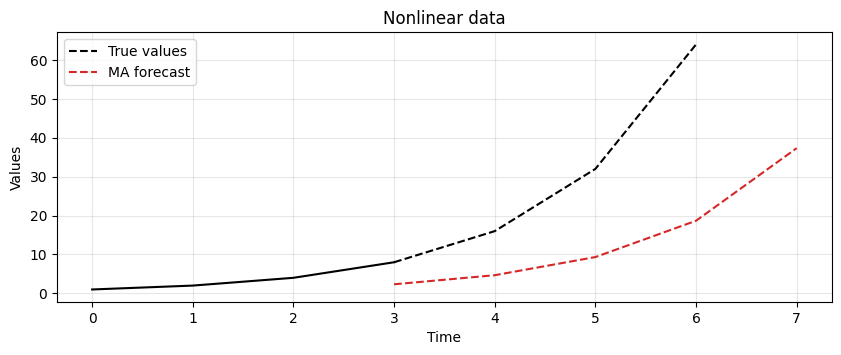

In [123]:
t = np.arange(len(ma_x))
run_sequence_plot(t[:-4], ma_x[:-4], title="Nonlinear data")
plt.plot(t[-5:], ma_x[-5:], 'k', label="True values", linestyle='--')
plt.plot(t, ma_forecast, 'tab:red', label="MA forecast", linestyle='--')
plt.legend(loc='upper left');

- The result shows that MA is lagging behind the actual signal.
- In this case, it is not able to keep up with changes in the trend.
- The lag of MA is also reflected in the forecasts it produces.

- Let's focus on the forecasting formula we just defined. 
- While easy to understand, one of its properties may not be obvious.
- What's the lag associated with this technique? 
- In other words, after how many time steps do we see a local change in the underlying signal?

- The answer is: $\frac{(P+1)}{2}$. 
- For example, say you're averaging the past 5 values to make the next prediction.
- Then the forecast value that most closely reflects the current value will appear after $\frac{5+1}{2} = 3$ time steps.
- Clearly, the lag increases as you increase the window size for averaging. 

- One might reduce the window size to obtain a more responsive model. 
- However, a window size that's too small will chase noise in the data as opposed to extracting the pattern. 
- There is a tradeoff between *responsiveness* and *robustness to noise*. 
- The best answer lies somewhere in between and requires careful tuning to determine which setup is best for a given dataset and problem at hand. 

- Let's make a practical example to show this tradeoff.
- We will generate some toy data and apply a MA with different window sizes. 
- To make things more clear, we generate again data with trend and seasonality, but we add more noise.

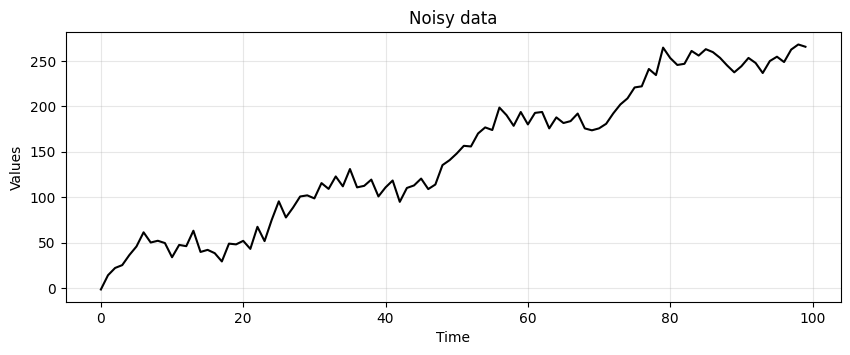

In [124]:
noisy_noise = np.random.normal(loc=0, scale=8.0, size=len(time))
noisy_trend = time * 2.75
noisy_seasonality = 10 + np.sin(time * 0.25) * 20
noisy_data = noisy_trend + noisy_seasonality + noisy_noise

run_sequence_plot(time, noisy_data, title="Noisy data");

In [125]:
# Compute MA with different window sizes
lag_2 = moving_average(noisy_data, window=3)
lag_3 = moving_average(noisy_data, window=5)
lag_5 = moving_average(noisy_data, window=9)
lag_10 = moving_average(noisy_data, window=19)

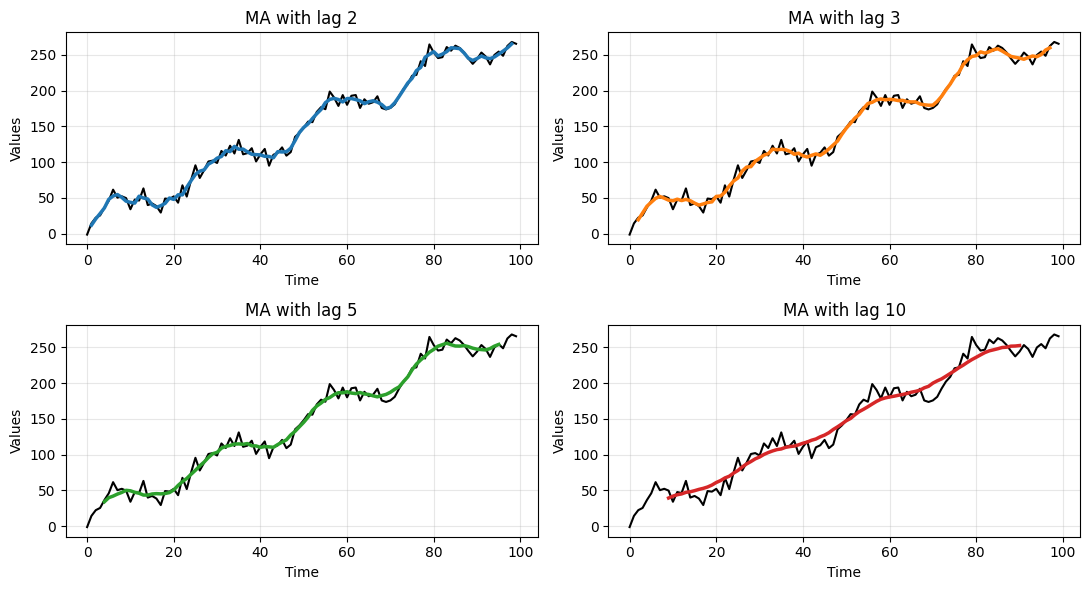

In [126]:
_, axes = plt.subplots(2,2, figsize=(11,6))
axes[0,0] = run_sequence_plot(time, noisy_data, title="MA with lag 2", ax=axes[0,0])
axes[0,0].plot(time[1:-1], lag_2, color='tab:blue', linewidth=2.5)
axes[0,1] = run_sequence_plot(time, noisy_data, title="MA with lag 3", ax=axes[0,1])
axes[0,1].plot(time[2:-2], lag_3, color='tab:orange', linewidth=2.5)
axes[1,0] = run_sequence_plot(time, noisy_data, title="MA with lag 5", ax=axes[1,0])
axes[1,0].plot(time[4:-4], lag_5, color='tab:green', linewidth=2.5)
axes[1,1] = run_sequence_plot(time, noisy_data, title="MA with lag 10", ax=axes[1,1])
axes[1,1].plot(time[9:-9], lag_10, color='tab:red', linewidth=2.5)
plt.tight_layout();

- Clearly, the larger the window size the smoother the data.
- This allows to get rid of the noise but, eventually, also the underlying signal is smoothed out. 

---

## Exponential Smoothing

There are three key exponential smoothing techniques:

|Type | Capture trend | Capture seasonality|
|:----:|:---------------:|:--------------------:|
|Single Exponential Smoothing | ❌ | ❌ |
|Double Exponential Smoothing | ✅ | ❌ |
|Triple Exponential Smoothing | ✅ | ✅ |

We don't have enough time to go through the math of how it works, but it is analogous to the WMA

- The basic formulation is:

$$S(t) = \alpha X(t) + (1-\alpha)S(t-1)$$ 

- where:
    - $S(t)$ is the smoothed value at time *t*,
    - $\alpha$ is a smoothing constant,
    - $X(t)$ is the value of the series at time *t*.

![EMA](media/EMA.gif)

- Double Exponential Smoothing also has is able to pick up on trend by using an estimated trend.
- Triple Exponential Smoothing is able to additionally pick up on seasonality.

- Let's relax off the math, and demonstrate Exponential Smoothing by letting `statsmodels` do the work for us.

- We will holdout the last 5 samples from the dataset (i.e., they become the *test set*).
- We will compare the predictions made by the models with these values.

In [127]:
# Train/test split
train = trend_seasonality[:-5]
test = trend_seasonality[-5:]

### Simple Average

- This is a very crude model to say the least.
- It can at least be used as a baseline. 
- Any model we try moving forward should do much better than this one. 

In [128]:
# find mean of series
trend_seasonal_avg = np.mean(train)

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float')

# mse
simple_mse = mse(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [103.69796574 103.69796574 103.69796574 103.69796574 103.69796574]
MSE:  10145.54276901901


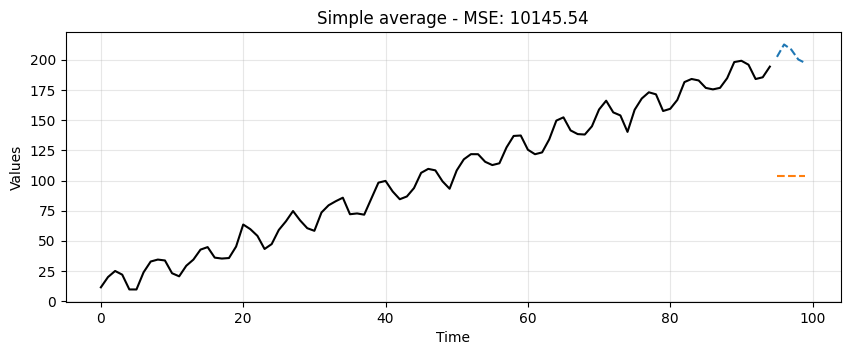

In [129]:
ax = run_sequence_plot(time[:-5], train, title=f"Simple average - MSE: {simple_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], simple_avg_preds, color='tab:orange', linestyle="--", label="preds");

### Single Exponential

In [130]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [194.37115555 194.37115555 194.37115555 194.37115555 194.37115555]
MSE:  129.47602005761325


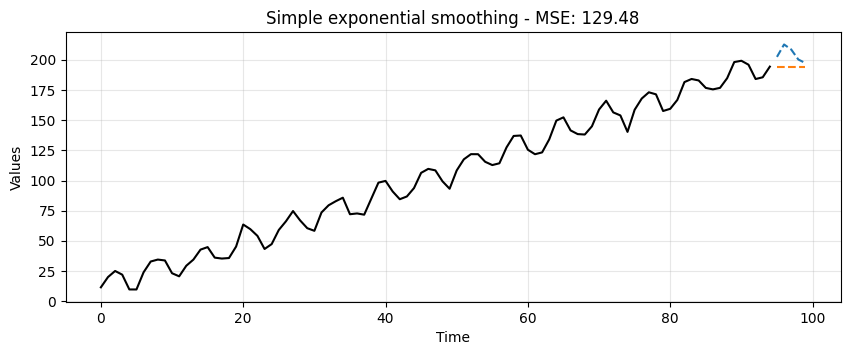

In [131]:
ax = run_sequence_plot(time[:-5], train, title=f"Simple exponential smoothing - MSE: {single_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], single_preds, color='tab:orange', linestyle="--", label="preds");

- Although better than the simple average method, it's still pretty crude. 
- Notice how the forecast is just a horizontal line. 
- Single Exponential Smoothing cannot pick up neither trend nor seasonality.

### Double Exponential

In [132]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [196.20305952 198.03496347 199.86686742 201.69877137 203.53067532]
MSE:  74.27670577417757


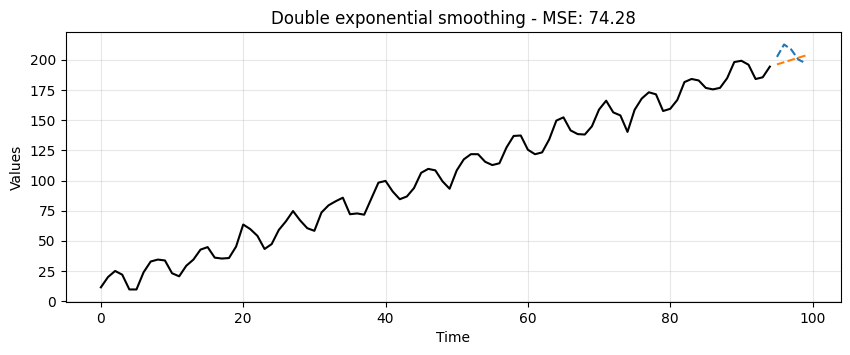

In [133]:
ax = run_sequence_plot(time[:-5], train, title=f"Double exponential smoothing - MSE: {double_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], double_preds, color='tab:orange', linestyle="--", label="preds");

- Double Exponential Smoothing can pickup on trend, which is exactly what we see here. 
- This is a significant leap but no quite yet the prediction we would like to get.

In [134]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [207.46349451 210.02635851 208.80394709 202.63149745 201.40914672]
MSE:  10.983389218197164


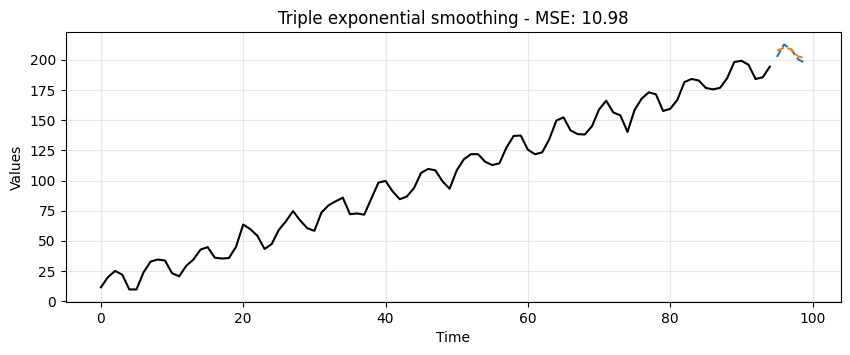

In [135]:
ax = run_sequence_plot(time[:-5], train, title=f"Triple exponential smoothing - MSE: {triple_mse:.2f}")
ax.plot(time[-5:], test, color='tab:blue', linestyle="--", label="test")
ax.plot(time[-5:], triple_preds, color='tab:orange', linestyle="--", label="preds");

- Triple Exponential Smoothing picks up trend and seasonality. 
- Clearly, this is the most suitable approach for this data.
- We can summarize the results in the following table:

In [136]:
data_dict = {'MSE':[simple_mse, single_mse, double_mse, triple_mse]}
df = pd.DataFrame(data_dict, index=['simple', 'single', 'double', 'triple'])
print(df)

                 MSE
simple  10145.542769
single    129.476020
double     74.276706
triple     10.983389


---

## Summary

In this lecture we learned

1. What is smoothing and why it is necessary.
2. Some common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.
---

Exercise: Try it yourself! Pick any stock and use the  first, second, and third order EMA to forecast the values.

In [158]:
def forecast_stock(ticker, start=None, end=None, test_size=5, plot=True):
    
    # Download stock data
    data = yf.download(ticker, start=start, end=end)
    series = data['Close'].dropna().values
    time = np.arange(len(series))

    # Train/test split
    train = series[:-test_size]
    test = series[-test_size:]

    # Estimate seasonal period using FFT
    def estimate_seasonal_period(y):
        y = np.array(y)
        y_centered = y - np.mean(y)
        fft_vals = np.fft.fft(y_centered)
        fft_mag = np.abs(fft_vals)[:len(y)//2]
        freqs = np.fft.fftfreq(len(y), d=1)[:len(y)//2]
        fft_mag[0] = 0
        dominant_freq = freqs[np.argmax(fft_mag)]
        return max(1, int(round(1 / dominant_freq)))

    seasonal_period = estimate_seasonal_period(train)
    print(f"Estimated seasonal period: {seasonal_period}")

    results = {}

    # Simple Exponential Smoothing
    ses_model = SimpleExpSmoothing(train).fit(optimized=True)
    ses_preds = ses_model.forecast(len(test))
    ses_mse = mse(test, ses_preds)
    results['SES'] = {'preds': ses_preds, 'mse': ses_mse}

    # Holt's Linear Trend
    holt_model = Holt(train).fit(optimized=True)
    holt_preds = holt_model.forecast(len(test))
    holt_mse = mse(test, holt_preds)
    results['Holt'] = {'preds': holt_preds, 'mse': holt_mse}

    # Holt-Winters (Triple Exponential Smoothing)
    hw_model = ExponentialSmoothing(
        train, trend="additive", seasonal="additive",
        seasonal_periods=seasonal_period
    ).fit(optimized=True)
    hw_preds = hw_model.forecast(len(test))
    hw_mse = mse(test, hw_preds)
    results['Holt-Winters'] = {'preds': hw_preds, 'mse': hw_mse}

    # Plotting
    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(time, series, color='tab:blue', label='Full series')
        plt.plot(time[-test_size:], test, 'b--', label='Test data')
        plt.plot(time[-test_size:], ses_preds, 'orange', linestyle='--', label='First order exponential preds')
        plt.plot(time[-test_size:], holt_preds, 'green', linestyle='--', label='Second order exponential preds')
        plt.plot(time[-test_size:], hw_preds, 'red', linestyle='--', label='Third order exponential preds')
        plt.title("Stock Forecasting")
        plt.legend()
        plt.show()

    return results


[*********************100%***********************]  1 of 1 completed

Estimated seasonal period: 3


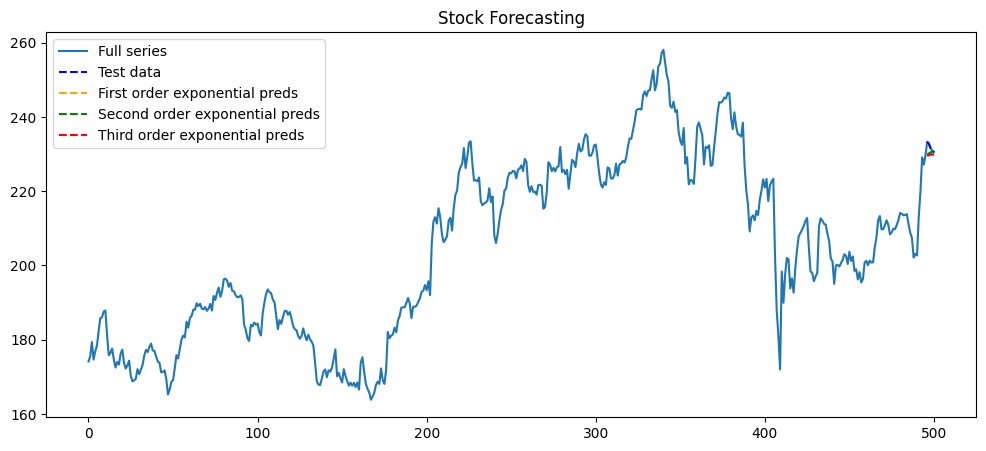

SES MSE: 5.89
SES Predictions: [229.64999386 229.64999386 229.64999386 229.64999386 229.64999386]
Holt MSE: 3.98
Holt Predictions: [229.91659843 230.183203   230.44980756 230.71641213 230.9830167 ]
Holt-Winters MSE: 5.50
Holt-Winters Predictions: [229.57441512 229.68638922 229.98644734 229.9108686  230.0228427 ]


In [165]:
results = forecast_stock("AAPL", start="2023-08-20", end="2025-08-20", test_size=5)
for method, res in results.items():
    print(f"{method} MSE: {res['mse']:.2f}")
    print(f"{method} Predictions: {res['preds']}")